In [1]:
import itertools
import os
import numpy as np
import pandas as pd
import cv2
import mrcnn.model as modellib
from mrcnn import visualize
from data_processing import read_json_conf_file, resize_image
from models import MrcnnConfigInference
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import random

Using TensorFlow backend.


In [2]:
VISUALIZE = True

conf_file = read_json_conf_file('../mrcnn_config.json')
paths, learning_params, model_params = conf_file['paths'], conf_file['learning_params'], conf_file['model_params']

inference_config = MrcnnConfigInference()
model = modellib.MaskRCNN(mode='inference',
                          config=inference_config,
                          model_dir=paths['MODEL_DIR'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [3]:
weights_path = os.path.join(paths["FINAL_WEIGHTS_PATH"], str('mask_rcnn_' + model_params["NAME"] + '.h5'))
if not os.path.isfile(weights_path):
    weights_path = paths['COCO_WEIGHTS_PATH']

print('Using pretrained weights from:', weights_path)

Using pretrained weights from: ../final_weights_dir/mask_rcnn_fashion.h5


In [4]:
model.load_weights(weights_path, by_name=True)

sample_df = pd.read_csv(paths['SAVED_DF_PATH'])


def to_rle(bits):
    rle = []
    pos = 0
    for bit, group in itertools.groupby(bits):
        group_list = list(group)
        if bit:
            rle.extend([pos, sum(group_list)])
        pos += len(group_list)
    return rle

### Redefine this function from visualize model due to error with labels

In [10]:
def display_instances(image, boxes, masks, class_ids='', class_names='',
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or visualize.random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
#             class_id = class_ids[i]
#             score = scores[i] if scores is not None else None
#             label = class_names[class_id]
            x = random.randint(x1, (x1 + x2) // 2)
#             caption = "{} {:.3f}".format(label, score) if score else label
            caption = 'some label'
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = visualize.apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = visualize.find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()

[32 32  2 34]
[32, 32, 2, 34]


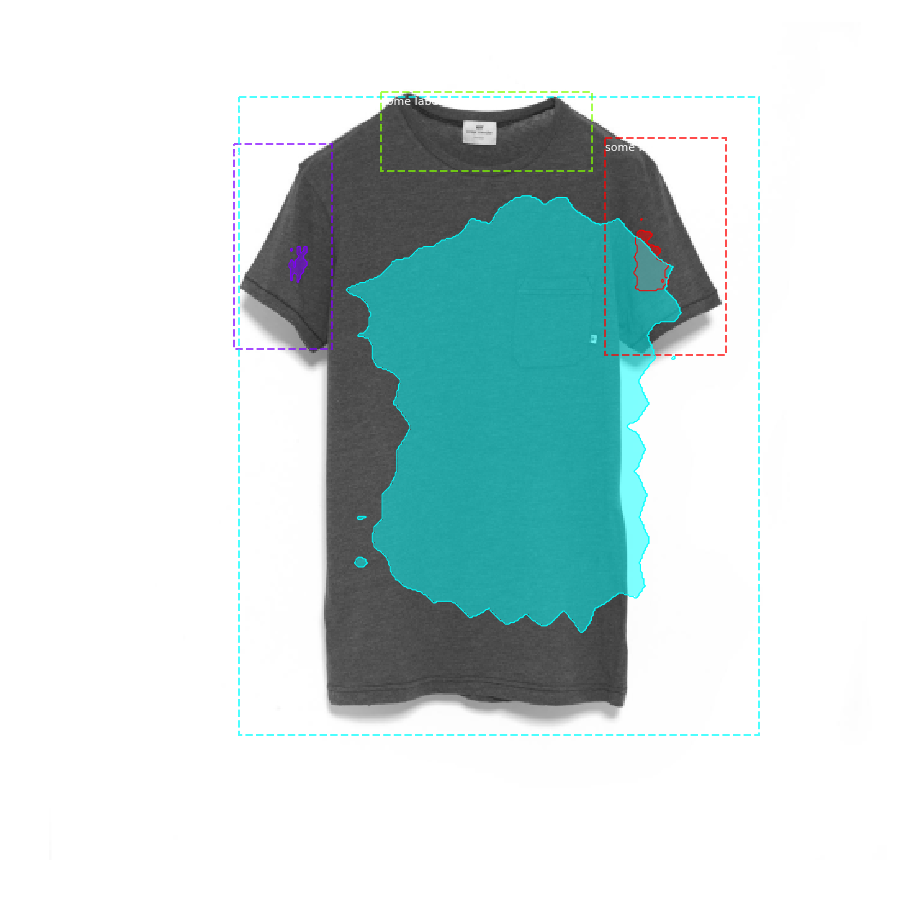

[32  2 32 32  2 34]
[32, 2, 32, 32, 2, 34]


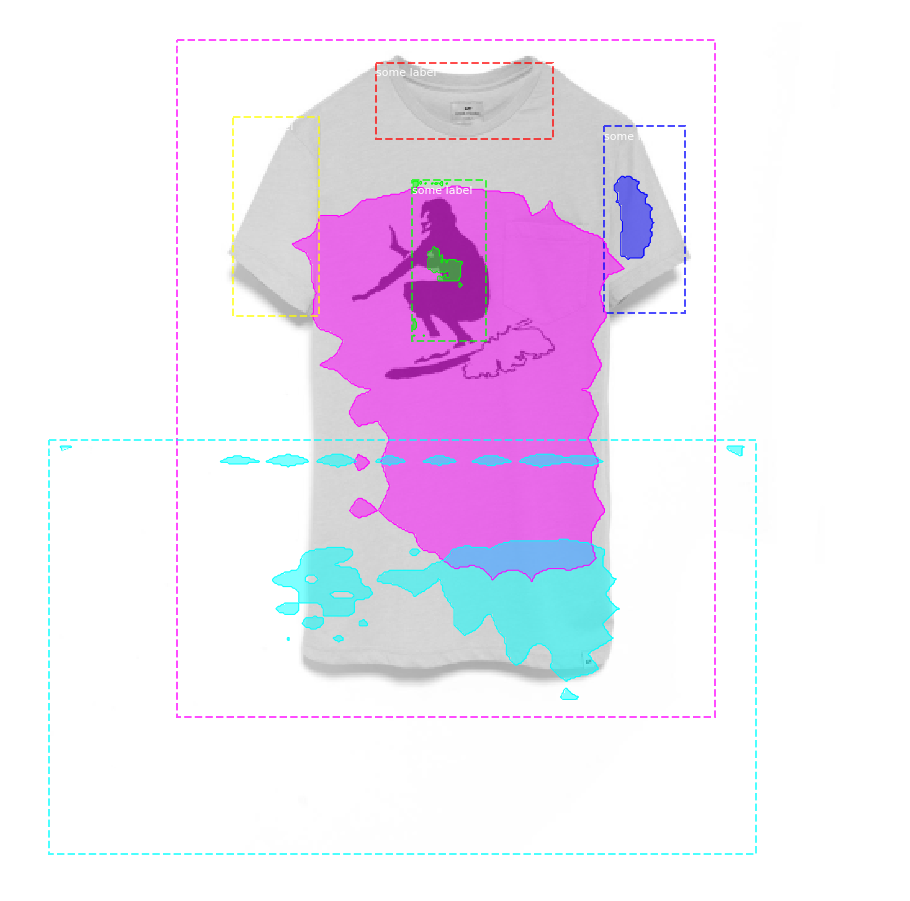

[32  2 32 34]
[32, 2, 32, 34]


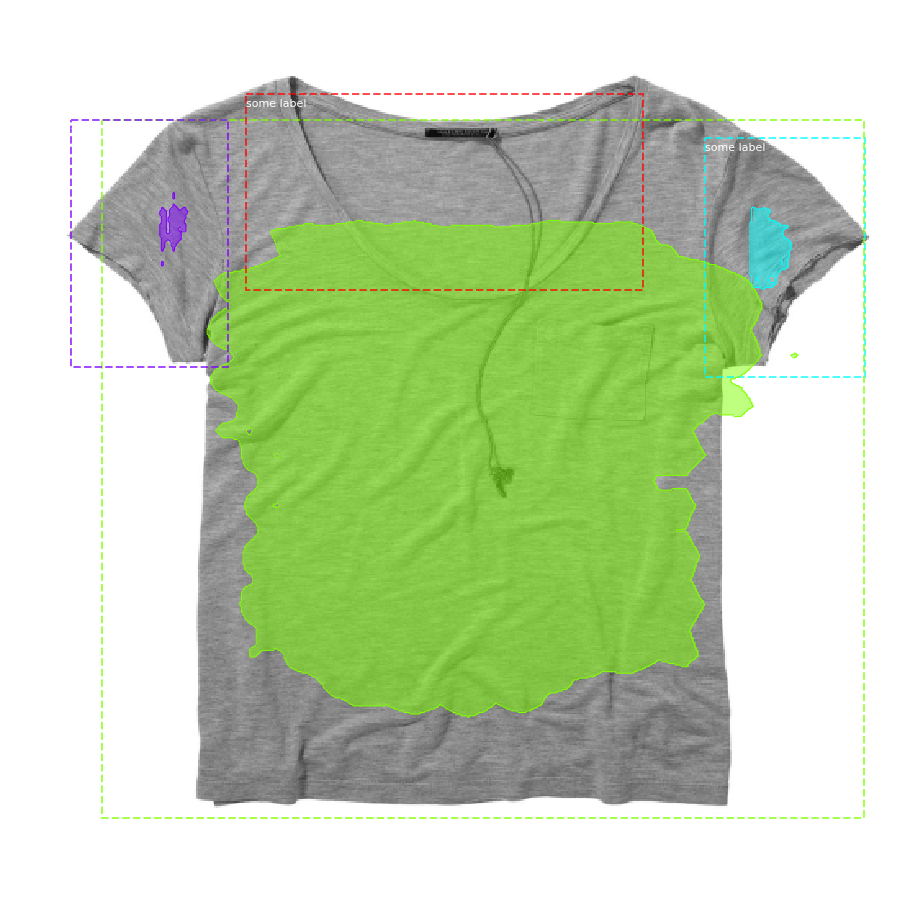

[32  2 32 34]
[32, 2, 32, 34]


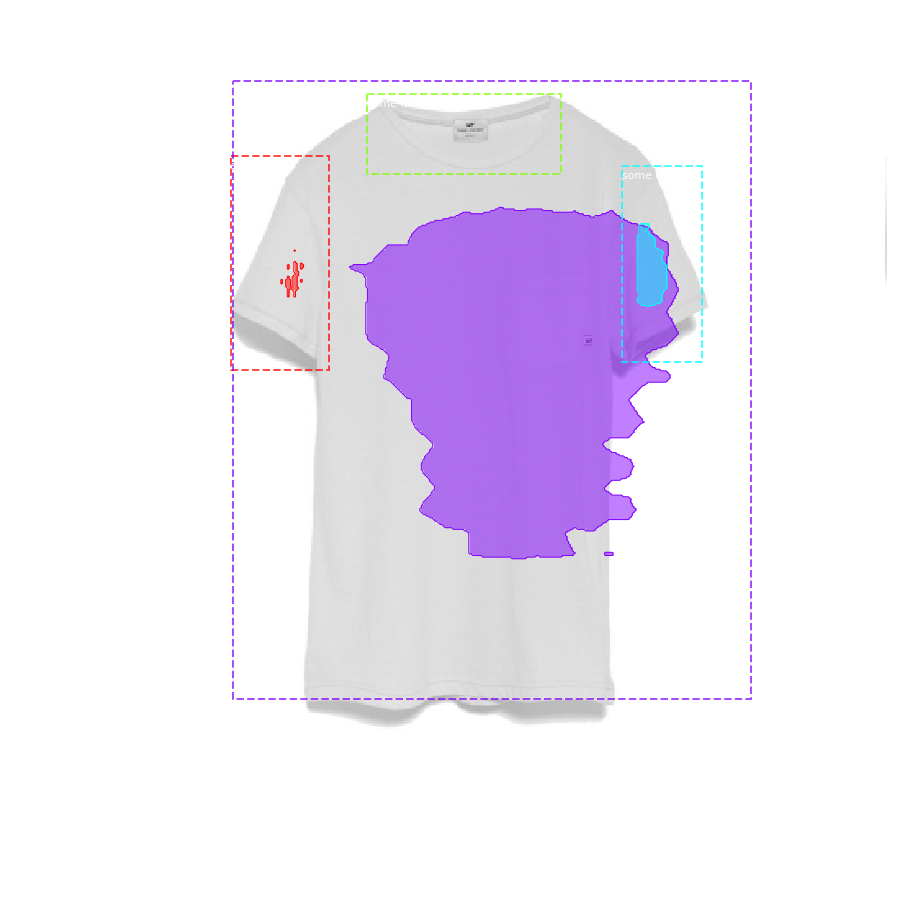

[32 32  2  2]
[32, 32, 2, 2]


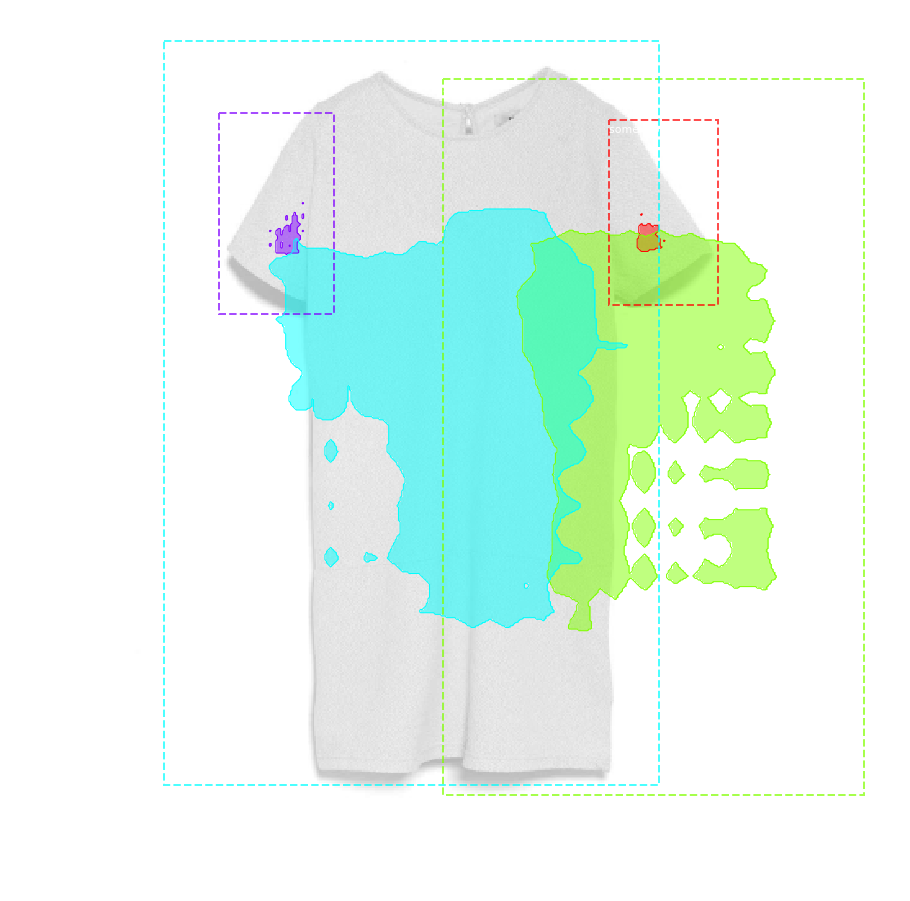

[32  2 32  2 32]
[32, 2, 32, 2, 32]


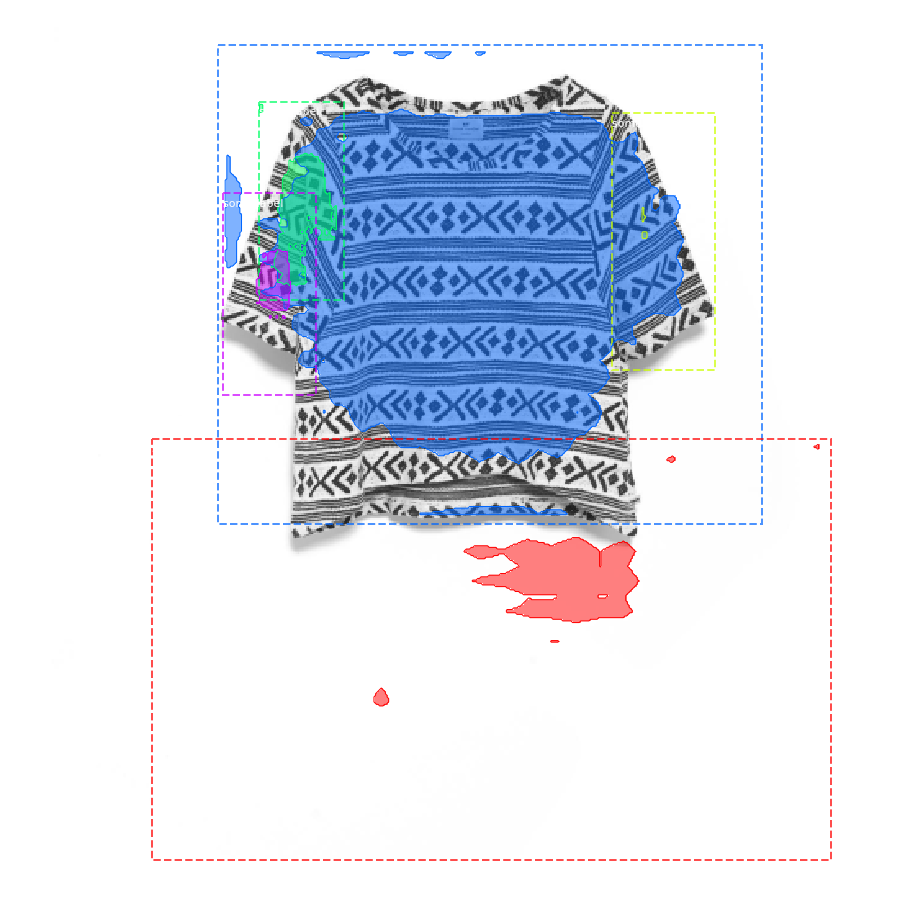

[ 2 32 32]
[2, 32, 32]


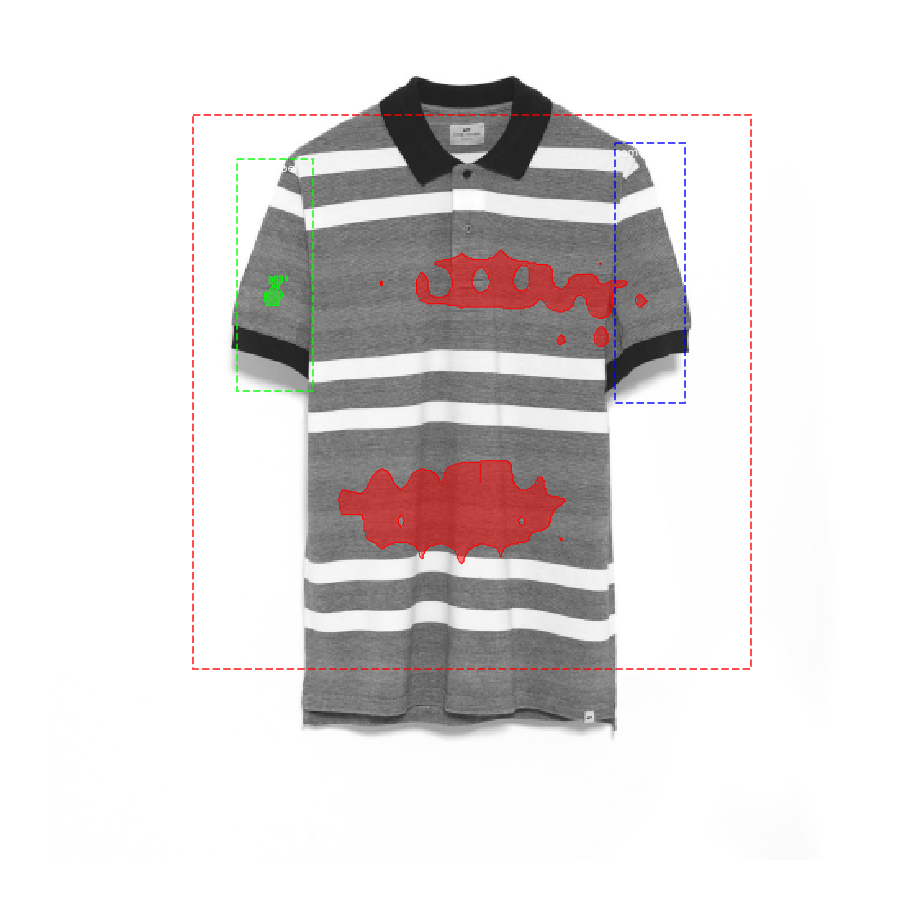

[2]
[2]


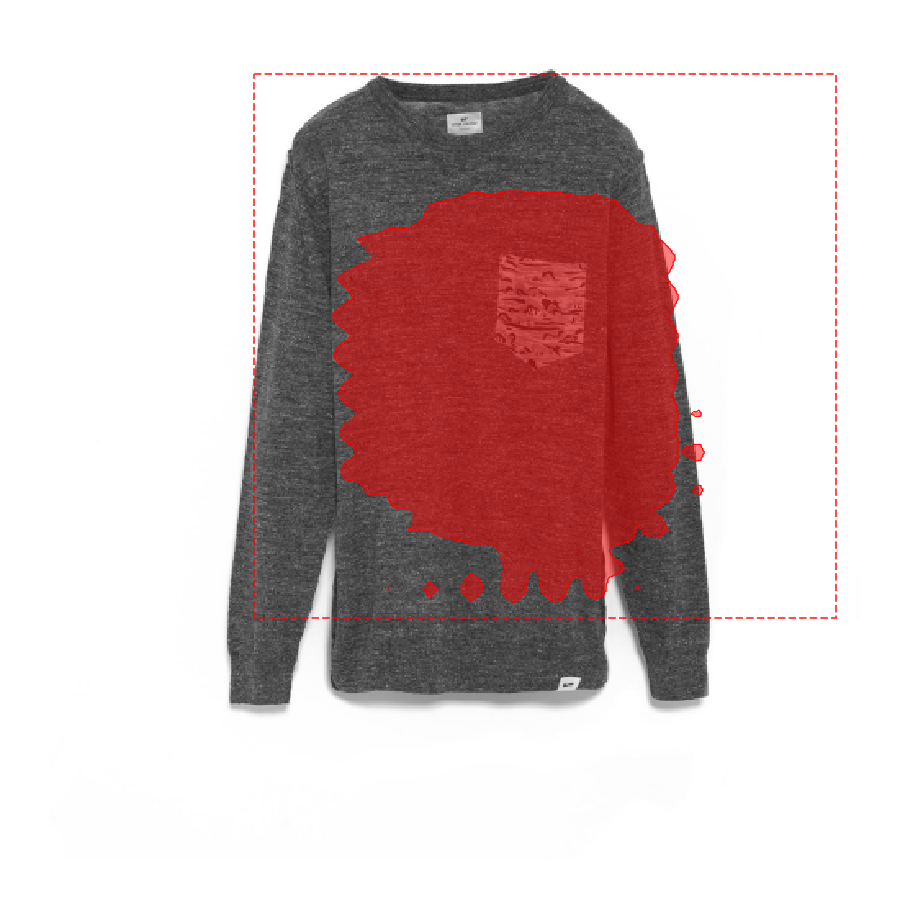

[32 32  2  2 34]
[32, 32, 2, 2, 34]


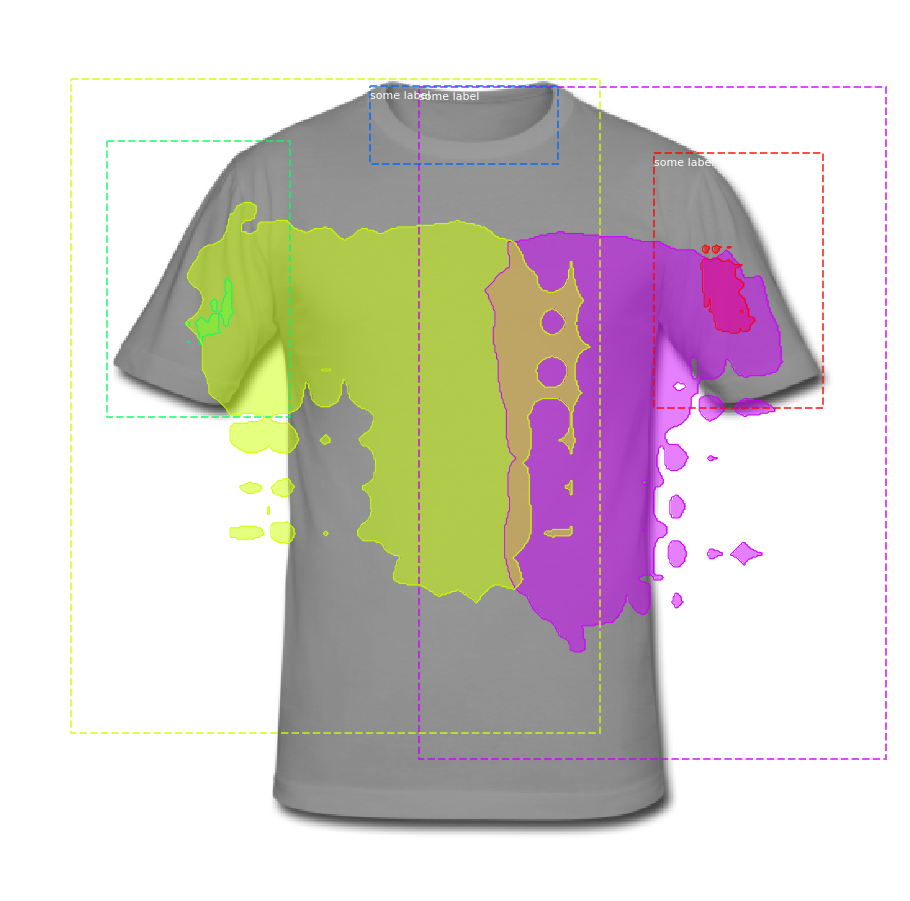

[32 32  2]
[32, 32, 2]


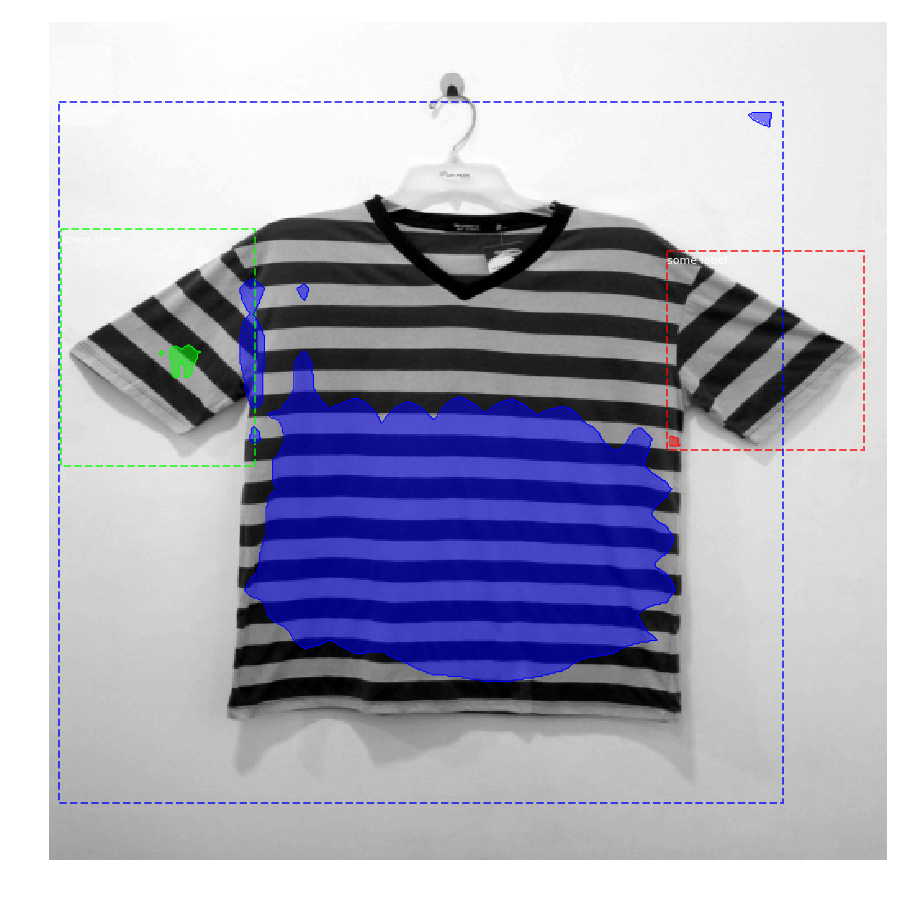

In [11]:
already_visualized = []
for i, row in sample_df.iterrows():
    img = resize_image(os.path.join('..', 'img_to_take', row['ImageId']), 512)
    result = model.detect([img])[0]
    if result['masks'].size > 0:
        masks = result['masks']
        for m in range(masks.shape[-1]):
            mask = masks[:, :, m].ravel(order='F')
            rle = to_rle(mask)
            label = result['class_ids'][m] - 1

        if VISUALIZE and not row['ImageId'] in already_visualized:
            masks = np.zeros((img.shape[0], img.shape[1], result['masks'].shape[-1]), dtype=np.uint8)
            for m in range(result['masks'].shape[-1]):
                masks[:, :, m] = cv2.resize(result['masks'][:, :, m].astype('uint8'),
                                            (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
            already_visualized.append(row['ImageId'])
            
            y_scale = img.shape[0] / 512
            x_scale = img.shape[1] / 512
            rois = (result['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
            print(result['class_ids'])
            print(list(result['class_ids']))
            display_instances(img, rois, masks, result['class_ids'], [result['class_ids']], 
                                        colors=None) 
        else:
            continue